In [1]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
import pickle
from scipy.misc import imresize
import torch
import imp
from IPython.lib.deepreload import reload

In [1]:
# wide notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

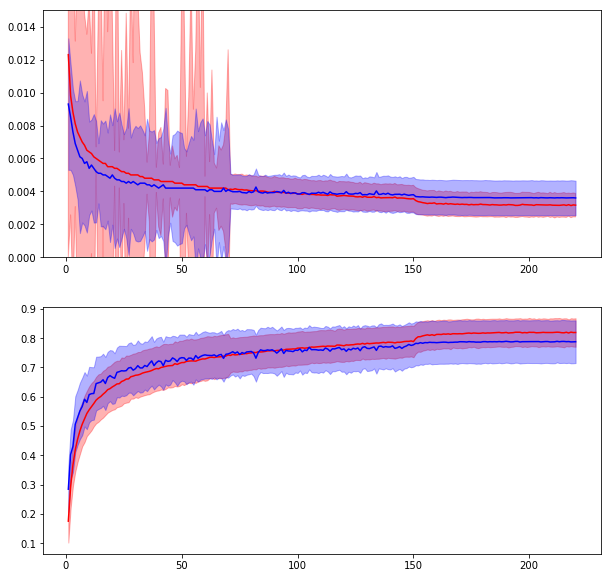

In [3]:
data = pickle.load(open("1-220.dat"))

losses = list()
acces = list()
losses_avg = list()
acces_avg = list()

losses_val = list()
acces_val = list()
losses_avg_val = list()
acces_avg_val = list()

train_data_count = 1854
val_data_count = 247

def convert(raw_data, loss_list, acc_list, avg_loss_list, avg_acc_list):
    acc_sum = 0.
    loss_sum = 0.
    for i, it in enumerate(raw_data):
        if len(it) == 2:
            loss = float(it[0]) * (i + 1) - loss_sum
            acc = float(it[1]) * (i + 1) - acc_sum
            loss_sum = float(it[0]) * (i + 1)
            acc_sum = float(it[1]) * (i + 1)
        elif len(it) == 4:
            loss = float(it[2])
            acc = float(it[3])
            loss_sum += loss
            acc_sum += acc
        else:
            assert False
        loss_list.append(loss)
        acc_list.append(acc)
    avg_loss_list.append(loss_sum / len(raw_data))
    avg_acc_list.append(acc_sum / len(raw_data))

for epoch in data:
    acc_sum = 0.
    loss_sum = 0.
    train_data = data[epoch][:train_data_count]
    val_data = data[epoch][train_data_count:]
    assert len(train_data) == train_data_count and len(val_data) == val_data_count
    convert(train_data, losses, acces, losses_avg, acces_avg)
    convert(val_data, losses_val, acces_val, losses_avg_val, acces_avg_val)
    
def errorfill(x, y, yerr, color=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, color=color)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill)

def get_yerr(y, mean_size):
    return np.array(y).reshape((-1, mean_size)).std(-1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

errorfill(np.arange(len(losses_avg), dtype=np.float32)+1, losses_avg, get_yerr(losses, train_data_count), color="r", ax=ax1)
errorfill(np.arange(len(losses_avg_val), dtype=np.float32)+1, losses_avg_val, get_yerr(losses_val, val_data_count), color="b", ax=ax1)
ax1.set_ylim(0.0, 0.015)

errorfill(np.arange(len(acces_avg), dtype=np.float32)+1, acces_avg, get_yerr(acces, train_data_count), color="r", ax=ax2)
errorfill(np.arange(len(acces_avg_val), dtype=np.float32)+1, acces_avg_val, get_yerr(acces_val, val_data_count), color="b", ax=ax2)
# ax2.set_ylim(0.0, 0.015)


In [2]:
base_dir = '/home/qite/my/pytorch-pose/'
sys.path.insert(0, base_dir)
import pose
# def import_pose(base_dir):
#     module_name = 'pose'
#     fp, pathname, description = imp.find_module(module_name, [base_dir])

#     try:
#         return imp.load_module(module_name, fp, pathname, description)
#     finally:
#         if fp:
#             fp.close()
# pose = import_pose(base_dir)

In [3]:
mpii = pose.datasets.Mpii(jsonfile=base_dir + '/data/mpii/mpii_annotations.json',
                          img_folder=base_dir + '/data/mpii/images',
                          meanstd_file=base_dir + '/data/mpii/mean.pth.tar',
                          sigma_pts=1, label_type="Gaussian", single_person=True,
                          train=False, label_data=pose.datasets.Mpii.LABEL_POINTS_MAP)
selective = np.load(base_dir + '/experiments/sel.npy')
preds = np.load(base_dir + "/checkpoint/mpii/hg_inf_S3_B1_5/preds_200.npy")

In [ ]:
# part
for index in range(len(mpii)):
    print("index: {}".format(index))
    fig, axs = plt.subplots(4, 8, figsize=(30, 15), gridspec_kw={'wspace': 0.08, 'hspace': 0.08})
    img = mpii[index][0]
    img = img.numpy().transpose(1,2,0) + mpii.mean

    timg_total = imresize(np.asscalar(preds)['parts'].numpy()[index, :15].max(0), img.shape[:2], mode='F')
    timg2_total = imresize(np.asscalar(preds)['parts'].numpy()[index, 15:].max(0), img.shape[:2], mode='F')
    
    axs.flat[0].imshow(img)
    axs.flat[0].imshow(timg_total, alpha=0.3)
    axs.flat[0].axis('off')
    
    axs.flat[1].imshow(img)
    axs.flat[1].imshow(timg2_total, alpha=0.3)
    axs.flat[1].axis('off')
    
    for i in range(0, 15):
        ax = axs.flat[(i+1)*2]
        ax2 = axs.flat[(i+1)*2+1]
        timg = imresize(np.asscalar(preds)['parts'].numpy()[index, i], img.shape[:2], mode='F')
        timg2 = imresize(np.asscalar(preds)['parts'].numpy()[index, 15 + i], img.shape[:2], mode='F')
        ax.imshow(img)
        ax.imshow(timg, alpha=0.3)
        ax.axis('off')
        ax2.imshow(img)
        ax2.imshow(timg2, alpha=0.3)
        ax2.axis('off')
    plt.show()

In [ ]:
# point
point_preds = np.asscalar(preds).numpy()
for index in range(len(mpii)):
    img, _, meta = mpii[index]
    if meta['index'] >= point_preds.shape[0]:
        # skip
        continue
    
    print("index: {}".format(index))
    fig, axs = plt.subplots(5, 4, figsize=(20, 20), gridspec_kw={'wspace': 0.08, 'hspace': 0.08})
    
    img = img.numpy().transpose(1,2,0) + mpii.mean

    timg_total = imresize(point_preds[index].max(0), img.shape[:2], mode='F')
    
    axs.flat[0].imshow(img)
    axs.flat[0].imshow(timg_total, alpha=0.7, vmin=0., vmax=1.)
    axs.flat[0].axis('off')
    
    for i in range(1, axs.size):
        ax = axs.flat[i]
        ax.axis('off')
        if i > point_preds.shape[1]:
            continue
        timg = imresize(point_preds[index, i-1], img.shape[:2], mode='F')
        ax.imshow(img)
        mappable = ax.imshow(timg, alpha=0.7)
        fig.colorbar(mappable, ax=ax)

    plt.show()

In [4]:
model = pose.models.PathHourglassNet(pose.models.Bottleneck, 
                                num_stacks=3,
                                num_blocks=1,
                                num_classes=16)

model = torch.nn.DataParallel(model).cuda()
checkpoint = torch.load(base_dir + "/checkpoint/mpii/hg_path_S3_B1_2/checkpoint_180.pth.tar")
model.load_state_dict(checkpoint['state_dict'])

In [ ]:
def my_forward(self, x):
    self = model.module
    out = []
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x) 

    x = self.layer1(x)  
    x = self.maxpool(x)
    x = self.layer2(x)  
    x = self.layer3(x)  

    start_x = x

    for i in range(self.num_stacks):
        cur_classes = self.num_classes if type(self.num_classes) is int else self.num_classes[i]

        y = self.hg[i](x)
        y = self.res[i](y)
        y = self.fc[i](y)
        score = self.score[i](y)
        out.append(score)
        if i < self.num_stacks-1:
            score_eh = self._enhance_score(score, i)
            start_ = self.start_res[i](start_x)
            score_ = self.score_res[i](self.score_[i](score_eh))
            # x = x + fc_ + score_
            x = start_ + score_

    return out

model.module.forward = my_forward
for index in range(50):
    print("index: {}".format(index))
    img, target, meta = mpii[index]
    input_var = torch.autograd.Variable(img.unsqueeze(0).cuda(), volatile=True)
    output = model.module(input_var)

In [23]:
layer_mean = np.zeros((2, 3))
layer_var = np.zeros((2, 3))
layer_count = 0
def my_forward(x):
    global layer_mean
    global layer_var
    global layer_count
    self = model.module
    out = []
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x) 

    x = self.layer1(x)  
    x = self.maxpool(x)
    x = self.layer2(x)  
    x = self.layer3(x)  

    for i in range(self.num_stacks):
        #cur_classes = self.num_classes if type(self.num_classes) is int else self.num_classes[i]

        y = self.hg[i](x)
        y = self.res[i](y)
        y = self.fc[i](y)
        score = self.score[i](y)
        out.append(score)
        if i < self.num_stacks-1:
            # score_eh = self._enhance_score(score, i)
            fc_ = self.fc_[i](y)
            score_ = self.score_[i](score)
            cur_mean = np.array([x.mean().data.cpu().numpy()[0], fc_.mean().data.cpu().numpy()[0], score_.mean().data.cpu().numpy()[0]])
            cur_var = np.array([x.var().data.cpu().numpy()[0], fc_.var().data.cpu().numpy()[0], score_.var().data.cpu().numpy()[0]])
            layer_mean[i] = ((layer_mean[i] * layer_count) + cur_mean) / (layer_count + 1)
            layer_var[i] = ((layer_var[i] * layer_count) + cur_var) / (layer_count + 1)
            x = x + fc_ + score_
    layer_count += 1

    return out

model.module.forward = my_forward
for index in range(50):
    print("index: {}".format(index))
    img, target, meta = mpii[index]
    input_var = torch.autograd.Variable(img.unsqueeze(0).cuda(), volatile=True)
    output = model.module(input_var)
print(layer_mean)
print(layer_var)

index: 0
index: 1
index: 2
index: 3
index: 4
index: 5
index: 6
index: 7
index: 8
index: 9
index: 10
index: 11
index: 12
index: 13
index: 14
index: 15
index: 16
index: 17
index: 18
index: 19
index: 20
index: 21
index: 22
index: 23
index: 24
index: 25
index: 26
index: 27
index: 28
index: 29
index: 30
index: 31
index: 32
index: 33
index: 34
index: 35
index: 36
index: 37
index: 38
index: 39
index: 40
index: 41
index: 42
index: 43
index: 44
index: 45
index: 46
index: 47
index: 48
index: 49
[[-0.11124076 -0.04717415 -0.00180089]
 [-0.1602158  -0.00073604  0.00699198]]
[[ 0.20474082  0.02721088  0.01954039]
 [ 0.25497905  0.01513646  0.02260493]]


In [ ]:
remain_model = False
for index in range(len(mpii)):
    print("index: {}".format(index))
    img, target, meta = mpii[index]
    input_var = torch.autograd.Variable(img.unsqueeze(0).cuda(), volatile=True)
    output = model(input_var)
    
    fig, axs = plt.subplots(16, 8, figsize=(40, 60), gridspec_kw={'wspace': 0.08, 'hspace': 0.08})

    img_show = imresize(img.numpy().transpose(1,2,0) + mpii.mean, (64, 64))
    map_acc = np.zeros((16, 64, 64))
    mask_acc = np.zeros((16, 64, 64))
    
    if remain_model:
        remain = np.ones((16, 64, 64))
    
    for j in range(len(output)):
        output_cur_cpu = output[j].data.cpu()[0].numpy()
        output_map = output_cur_cpu[:16]
        if not remain_model or j < len(output) - 1:
            output_mask = output_cur_cpu[16:]
        else:
            output_mask = None
        
        for c in range(16):
            map_ax = axs[c, 2+j*2]
            mask_ax = axs[c, 2+j*2+1]
            
            map_data = output_map[c]
            if remain_model:
                if output_mask is not None:
                    mask_data = remain[c] * output_mask[c]
                else:
                    mask_data = remain[c].copy()
                remain[c] -= mask_data
            else:
                mask_data = output_mask[c]
            
            mask_acc[c] += mask_data
            map_acc[c] += map_data * mask_data
            
            map_ax.axis('off')
            map_ax.imshow(img_show)
            map_cb = map_ax.imshow(map_data, alpha=0.7)
            fig.colorbar(map_cb, ax=map_ax)
            
            mask_ax.axis('off')
            if mask_data is not None:
                mask_ax.imshow(img_show)
                mask_cb = mask_ax.imshow(mask_data, alpha=0.7)
                fig.colorbar(mask_cb, ax=mask_ax)

    for c in range(16):
        map_acc_ax = axs[c, 0]
        mask_acc_ax = axs[c, 1]
        
        map_acc_ax.axis('off')
        map_acc_ax.imshow(img_show)
        map_acc_cb = map_acc_ax.imshow(map_acc[c], alpha=0.7)
        fig.colorbar(map_acc_cb, ax=map_acc_ax)
        
        mask_acc_ax.axis('off')
        mask_acc_cb = mask_acc_ax.imshow(mask_acc[c])
        fig.colorbar(mask_acc_cb, ax=mask_acc_ax)
    plt.show()